In [27]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.integrate
from collections import Counter
from scipy.optimize import curve_fit

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
MEDIUM_SIZE = 30
SMALL_SIZE = 22
SSSMALL_SIZE = 16

plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) 

In [2]:
def watershed_summary(filename):
    f = h5py.File(filename, 'r')
    watershed = f['watershed_group'][...]
    f.close()
    counts = Counter(watershed.flatten())
    clusters = np.array(list(counts.items()))
    cluster_n_size = clusters[:,1]
    cluster_radius = (3.0*(cluster_n_size*(720/320)**3)/(4.0*np.pi))**(1/3)
    return {'mean_radius':np.mean(cluster_radius), 'std_radius':np.std(cluster_radius), 
            'N':len(cluster_n_size), 'max_radius':np.max(cluster_radius)}

In [151]:
laniakea_vol_min = 1.7E6 # in (Mpc/h)^3
laniakea_vol_max = 2.3E6
laniakea_radius_min = (3.0*laniakea_vol_min/(4.0*np.pi))**(1/3)
laniakea_radius_max = (3.0*laniakea_vol_max/(4.0*np.pi))**(1/3)
# Numbers from https://arxiv.org/pdf/1907.06555.pdf
print(laniakea_radius_min, laniakea_radius_max)

74.0377883992306 81.88664456463073


In [3]:
#data = np.array([sigma_vals, half_r_mock, half_r_sim])
length_data = np.loadtxt("correlation_length.dat")
#R_s R_dd_gaussian_field R_dd_biased_tracers
length_data

array([[ 2. ,  6.5,  3. ],
       [ 6. , 17.3,  9.6],
       [10. , 27.2, 16.6],
       [14. , 37.5, 22.4],
       [20. , 51.6, 28. ]])

In [4]:
ws = {}
sigmas = [1.0, 3.0, 5.0, 7.0, 10.0]
for sigma in sigmas:
    filename = "watershed_mock_AbacusCosmos_720box_planck_00_0_FoF_vmax_300.0_sigma_{:.1f}_nside_360.hdf5".format(sigma)
    ws['abacus_{:.2f}'.format(sigma*2)] = watershed_summary(filename)

In [5]:
sigmas = [1.0, 3.0, 5.0, 7.0, 10.0]
for sigma in sigmas:
    filename = "watershed_mock_divergence_mesh_360_box_720_slim_{}.h5".format(int(sigma*2))
    ws['gauss_{:.2f}'.format(sigma*2)] = watershed_summary(filename)

In [6]:
max_r_abacus = []
max_r_gauss = []

mean_r_abacus = []
mean_r_gauss = []

std_r_abacus = []
std_r_gauss = []

n_abacus = []
n_gauss = []


sigmas = [1.0, 3.0, 5.0, 7.0, 10.0]
for sigma in sigmas:
    max_r_abacus.append(ws["abacus_{:.2f}".format(sigma*2)]["max_radius"])
    max_r_gauss.append(ws["gauss_{:.2f}".format(sigma*2)]["max_radius"])
    mean_r_abacus.append(ws["abacus_{:.2f}".format(sigma*2)]["mean_radius"])
    mean_r_gauss.append(ws["gauss_{:.2f}".format(sigma*2)]["mean_radius"])
    std_r_abacus.append(ws["abacus_{:.2f}".format(sigma*2)]["std_radius"])
    std_r_gauss.append(ws["gauss_{:.2f}".format(sigma*2)]["std_radius"])
    n_abacus.append(ws["abacus_{:.2f}".format(sigma*2)]["N"])
    n_gauss.append(ws["gauss_{:.2f}".format(sigma*2)]["N"])

max_r_abacus = np.array(max_r_abacus)
max_r_gauss = np.array(max_r_gauss)
    
mean_r_abacus = np.array(mean_r_abacus)
mean_r_gauss = np.array(mean_r_gauss)

std_r_abacus = np.array(std_r_abacus)
std_r_gauss = np.array(std_r_gauss)

n_abacus = np.array(n_abacus)
n_gauss = np.array(n_gauss)

In [28]:
def func(x, a):
    return a * x 

[2.03085137] [[0.0585849]]
74.0377883992306 81.88664456463073


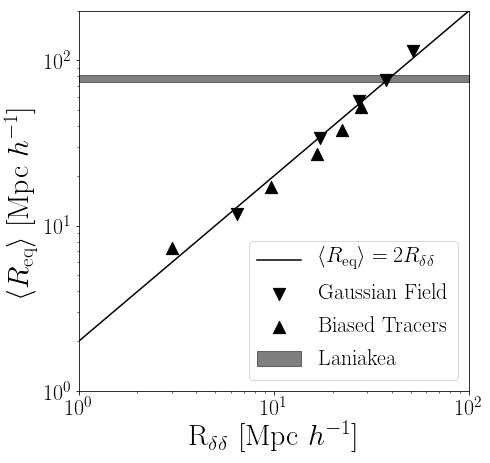

In [169]:
plt.figure(figsize=(7,7))

x = np.linspace(1,200, 100)
x_data = np.concatenate((length_data[:,1], length_data[:,2]))
y_data = np.concatenate((mean_r_gauss, mean_r_abacus))

plt.scatter(length_data[:,1], mean_r_gauss, 
            marker="v", s=150, label="Gaussian Field",color='black')
plt.scatter(length_data[:,2], mean_r_abacus, 
           marker="^", s=150, label="Biased Tracers", color='black')

popt, pcov = curve_fit(func, x_data, y_data)

print(popt, np.sqrt(pcov))
n = '({:.2f}\pm{:.2f})'.format(popt[0], np.sqrt(pcov[0,0]))
plt.plot(x, x*2, 
         label=r'$\langle R_{\mathrm{eq}} \rangle = 2 R_{\delta\delta}$', 
        color='black')

print(laniakea_radius_min, laniakea_radius_max)
dd = np.linspace(1,100)
plt.fill_between(dd, laniakea_radius_min*dd/dd, laniakea_radius_max*dd/dd, label='Laniakea', color='black', alpha=0.5)
plt.legend(loc=4, fontsize=SMALL_SIZE)
plt.loglog()
plt.xlim(1,100)
plt.ylim(1,200)
plt.xlabel(r"R$_{\delta\delta}$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.ylabel(r"$\langle R_{\mathrm{eq}} \rangle$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.savefig("summary_scales.pdf", bbox_inches='tight')

In [71]:
filename = 'watershed_mock_divergence_mesh_360_box_720_slim_10.h5'
f = h5py.File(filename, 'r')
watershed = f['watershed_group'][...]
f.close()
counts = Counter(watershed.flatten())
clusters = np.array(list(counts.items()))
cluster_n_size = clusters[:,1]
cluster_radius_gauss = (3.0*(cluster_n_size*(720/320)**3)/(4.0*np.pi))**(1/3)

filename = 'watershed_mock_AbacusCosmos_720box_planck_00_0_FoF_vmax_300.0_sigma_10.0_nside_360.hdf5'
f = h5py.File(filename, 'r')
watershed = f['watershed_group'][...]
f.close()
counts = Counter(watershed.flatten())
clusters = np.array(list(counts.items()))
cluster_n_size = clusters[:,1]
cluster_radius_abacus = (3.0*(cluster_n_size*(720/320)**3)/(4.0*np.pi))**(1/3)

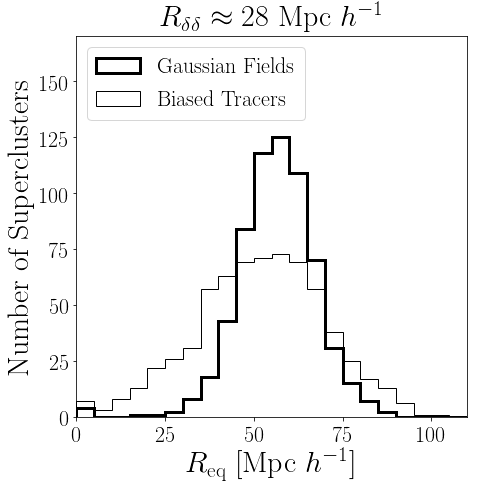

In [119]:
plt.figure(figsize=(7,7))

_ = plt.hist(cluster_radius_gauss, bins=np.arange(0,125,5), 
             color='black', histtype='step', linewidth=3, label='Gaussian Fields')
_ = plt.hist(cluster_radius_abacus, bins=np.arange(0,125,5),
             color='black', histtype='step', label='Biased Tracers')
plt.legend(loc=2, fontsize=SMALL_SIZE)
plt.xlabel(r"$R_{\mathrm{eq}}$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.ylabel(r"Number of Superclusters")
plt.title(r"$R_{\delta\delta} \approx 28\ \mathrm{Mpc}\ h^{-1}$")
plt.ylim([0,170])
plt.xlim([0,110])
plt.savefig("sizes_histogram.pdf", bbox_inches='tight')